# Exercise 1

In [1]:
import sys
print(sys.version)

import math
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# required to allow use of the suggested gaussian noise function
# import dill as pickle

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


### Defining a VGG11 Model

In [2]:
class VGG11(nn.Module):

    def __init__(self):
        super(VGG11, self).__init__()
        
        self.convolutionLayers = nn.Sequential(
            # conv3-64 
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # conv3-128
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # conv3-256
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # conv3-256
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # conv3-512
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # conv3-512
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            # conv3-512
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # conv3-512
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fullyConnectedLayers = nn.Sequential(
            # FC-4096
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # FC-4096
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # FC-10
            nn.Linear(4096, 10)
        )
            
    def forward(self, x):
        # convolution layers first
        x = self.convolutionLayers(x)
        x = torch.flatten(x, 1)
        # pass to fully connected layers 
        x = self.fullyConnectedLayers(x)
        
        return x

### Loading in MNIST Data

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Pad(2),
     transforms.Resize((32,32))])

batchSize = 256

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=2)

### Training The Model (currently running 5 epochs, reduce if not on GPU)

In [53]:
# check for gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = VGG11()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

trainingLoss = []
testLoss = []
testAccuracy = []
trainAccuracy = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save training loss
        running_loss += loss.item()
        
        # update progress
        print(f"Epoch {epoch+1}, Batch: {i+1}/{len(trainloader)}", end='\r')
        
    trainingLoss.append(running_loss / len(trainloader))

    # calculate training accuracy at each epoch
    trainCorrects = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            trainCorrects += (predicted == labels).sum().item()
    trainAccuracy.append(trainCorrects / len(trainloader.dataset))
    
    # calculate test accuracy at each epoch
    testCorrects = 0
    test_running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            testCorrects += (predicted == labels).sum().item()
            # also store test loss
#             loss = criterion(outputs, labels)
#             test_running_loss += loss.item()
    testAccuracy.append(testCorrects / len(testloader.dataset))
#     testLoss.append(test_running_loss)
    
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()

            # save training loss
            test_running_loss += loss.item()

            # update progress
            print(f"Epoch {epoch+1}, Batch: {i+1}/{len(trainloader)}", end='\r')

        testLoss.append(test_running_loss / len(testloader))
    print(f'Epoch {epoch+1} | Test Accuracy: {testAccuracy[-1]}')

Epoch 1 | Test Accuracy: 0.9877


KeyboardInterrupt: 

## 3.2
### Plots a - d

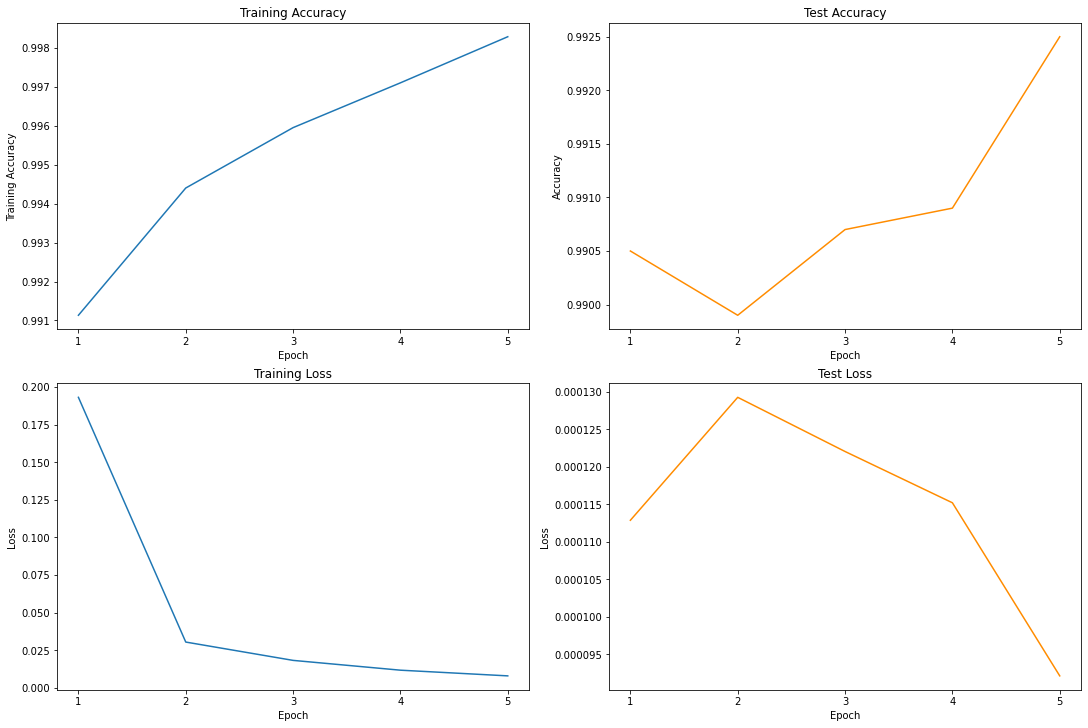

In [51]:
plt.rcParams["figure.figsize"] = (15,10)
fig, axs = plt.subplots(2, 2, constrained_layout = True)

# training accuracy plot
axs[0,0].plot(np.arange(1,6), trainAccuracy)
axs[0,0].set(xticks=np.arange(1,6))
axs[0,0].set_ylabel('Training Accuracy')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_title('Training Accuracy')

# test accuracy plot
axs[0,1].plot(np.arange(1,6), testAccuracy, color="darkorange")
axs[0,1].set(xticks=np.arange(1,6))
axs[0,1].set_ylabel('Accuracy')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_title('Test Accuracy')

# training loss plot
axs[1,0].plot(np.arange(1,6), trainingLoss)
axs[1,0].set(xticks=np.arange(1,6))
axs[1,0].set_ylabel('Loss')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_title('Training Loss')

# test loss plot
axs[1,1].plot(np.arange(1,6), testLoss, color="darkorange")
axs[1,1].set(xticks=np.arange(1,6))
axs[1,1].set_ylabel('Loss')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_title('Test Loss')

plt.show()

## 3.3
### Plot e (re-training to get correct, flipped accuracies per epoch)

In [6]:
hor_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     transforms.RandomHorizontalFlip(p=1)])

vert_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     torchvision.transforms.RandomVerticalFlip(p=1)])

batchSize = 256

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=2)

hor_testset = datasets.MNIST(root='./data', train=False, download=True, transform=hor_flip_transform)
hor_testloader = DataLoader(hor_testset, batch_size=batchSize, shuffle=False, num_workers=2)
vert_testset = datasets.MNIST(root='./data', train=False, download=True, transform=vert_flip_transform)
vert_testloader = DataLoader(vert_testset, batch_size=batchSize, shuffle=False, num_workers=2)

# check for gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = VGG11()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

trainingLoss = []
hor_testAccuracy = []
vert_testAccuracy = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save training loss
        running_loss += loss.item()
        
        # update progress
        print(f"Epoch {epoch+1}, Batch: {i+1}/{len(trainloader)}", end='\r')
        
    trainingLoss.append(running_loss / len(trainloader))
    
    # calculate test accuracy at each epoch (over both flips)
    hor_testCorrects = 0
    with torch.no_grad():
        for data in hor_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            hor_testCorrects += (predicted == labels).sum().item()
    hor_testAccuracy.append(hor_testCorrects / len(hor_testloader.dataset))
    print(f'Epoch {epoch+1} | Horizontal Flip Test Accuracy: {hor_testAccuracy[-1]}')
    
    vert_testCorrects = 0
    with torch.no_grad():
        for data in vert_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            vert_testCorrects += (predicted == labels).sum().item()
    vert_testAccuracy.append(vert_testCorrects / len(vert_testloader.dataset))
    print(f'Epoch {epoch+1} | Vertical Flip Test Accuracy: {vert_testAccuracy[-1]}\n---')

Epoch 1 | Horizontal Flip Test Accuracy: 0.4522
Epoch 1 | Vertical Flip Test Accuracy: 0.4148
---
Epoch 2 | Horizontal Flip Test Accuracy: 0.4846
Epoch 2 | Vertical Flip Test Accuracy: 0.425
---
Epoch 3 | Horizontal Flip Test Accuracy: 0.4673
Epoch 3 | Vertical Flip Test Accuracy: 0.4284
---
Epoch 4 | Horizontal Flip Test Accuracy: 0.4593
Epoch 4 | Vertical Flip Test Accuracy: 0.4198
---
Epoch 5 | Horizontal Flip Test Accuracy: 0.4558
Epoch 5 | Vertical Flip Test Accuracy: 0.4301
---


Text(0.5, 1.0, 'Flipped Test Accuracy')

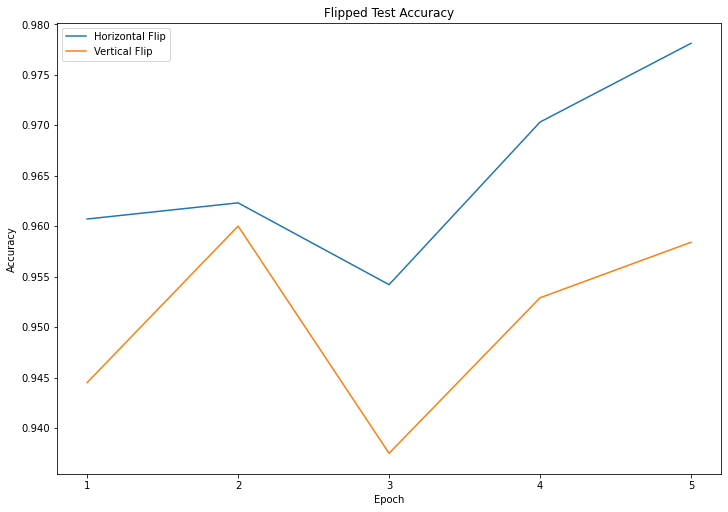

In [47]:
# test accuracy plot
plt.rcParams["figure.figsize"] = (10,7)
fig, ax = plt.subplots(constrained_layout = True)
ax.plot(np.arange(1,6), hor_testAccuracy, label = "Horizontal Flip")
ax.plot(np.arange(1,6), vert_testAccuracy, label = "Vertical Flip")
ax.set(xticks=np.arange(1,6))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend()
ax.set_title('Flipped Test Accuracy')

### Plot f (retraining to get proper accuracies per epoch)

In [38]:
# gaussian blur transform
# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745

class AddGaussianNoise(object):
    def __init__(self, var=1.):
        self.std = math.sqrt(var)
        
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std
    
    def __repr__(self):
        return self.__class__.__name__ + '(std={1})'.format(self.std)

small_gaussian_noise = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     AddGaussianNoise(0.01)])

med_gaussian_noise = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     AddGaussianNoise(0.1)])

large_gaussian_noise = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     AddGaussianNoise(1.)])

batchSize = 256

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=2)

small_noise_testset = datasets.MNIST(root='./data', train=False, download=True, transform=small_gaussian_noise)
small_noise_testloader = DataLoader(small_noise_testset, batch_size=batchSize, shuffle=False, num_workers=0)
med_noise_testset = datasets.MNIST(root='./data', train=False, download=True, transform=med_gaussian_noise)
med_noise_testloader = DataLoader(med_noise_testset, batch_size=batchSize, shuffle=False, num_workers=0)
large_noise_testset = datasets.MNIST(root='./data', train=False, download=True, transform=large_gaussian_noise)
large_noise_testloader = DataLoader(large_noise_testset, batch_size=batchSize, shuffle=False, num_workers=0)

# check for gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = VGG11()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

trainingLoss = []
small_noise_testAccuracy = []
med_noise_testAccuracy = []
large_noise_testAccuracy = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save training loss
        running_loss += loss.item()
        
        # update progress
        print(f"Epoch {epoch+1}, Batch: {i+1}/{len(trainloader)}", end='\r')
        
    trainingLoss.append(running_loss / len(trainloader))
    
    # calculate test accuracy at each epoch (over all noise levels)
    small_noise_testCorrects = 0
    with torch.no_grad():
        for data in small_noise_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            small_noise_testCorrects += (predicted == labels).sum().item()
    small_noise_testAccuracy.append(small_noise_testCorrects / len(small_noise_testloader.dataset))
    print(f'Epoch {epoch+1} | Var 0.01 Noise Test Accuracy: {small_noise_testAccuracy[-1]}')
    
    med_noise_testCorrects = 0
    with torch.no_grad():
        for data in med_noise_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            med_noise_testCorrects += (predicted == labels).sum().item()
    med_noise_testAccuracy.append(med_noise_testCorrects / len(med_noise_testloader.dataset))
    print(f'Epoch {epoch+1} | Var 0.1 Noise Test Accuracy: {med_noise_testAccuracy[-1]}')
    
    large_noise_testCorrects = 0
    with torch.no_grad():
        for data in large_noise_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            large_noise_testCorrects += (predicted == labels).sum().item()
    large_noise_testAccuracy.append(large_noise_testCorrects / len(large_noise_testloader.dataset))
    print(f'Epoch {epoch+1} | Var 1 Noise Test Accuracy: {large_noise_testAccuracy[-1]}\n---')

Epoch 1 | Var 0.01 Noise Test Accuracy: 0.9823
Epoch 1 | Var 0.1 Noise Test Accuracy: 0.9287
Epoch 1 | Var 1 Noise Test Accuracy: 0.3709
---
Epoch 2 | Var 0.01 Noise Test Accuracy: 0.9837
Epoch 2 | Var 0.1 Noise Test Accuracy: 0.921
Epoch 2 | Var 1 Noise Test Accuracy: 0.3651
---
Epoch 3 | Var 0.01 Noise Test Accuracy: 0.9829
Epoch 3 | Var 0.1 Noise Test Accuracy: 0.9393
Epoch 3 | Var 1 Noise Test Accuracy: 0.4037
---
Epoch 4 | Var 0.01 Noise Test Accuracy: 0.9861
Epoch 4 | Var 0.1 Noise Test Accuracy: 0.9209
Epoch 4 | Var 1 Noise Test Accuracy: 0.3861
---
Epoch 5 | Var 0.01 Noise Test Accuracy: 0.9864
Epoch 5 | Var 0.1 Noise Test Accuracy: 0.9344
Epoch 5 | Var 1 Noise Test Accuracy: 0.3872
---


In [46]:
# test accuracy plot
plt.rcParams["figure.figsize"] = (10,7)
fig, ax = plt.subplots(constrained_layout = True)
ax.plot(np.arange(1,6), small_noise_testAccuracy, label = "Noise Var=0.01")
ax.plot(np.arange(1,6), med_noise_testAccuracy, label = "Noise Var=0.1")
ax.plot(np.arange(1,6), large_noise_testAccuracy, label = "Noise Var=1")
ax.set(xticks=np.arange(1,6))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend()
ax.set_title('Gaussian Noise Test Accuracy')

Text(0.5, 1.0, 'Gaussian Noise Test Accuracy')

## 3.4
### Regularization

In [45]:
class AddGaussianNoise(object):
    def __init__(self, var=1.):
        self.std = math.sqrt(var)
        
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.std)

small_gaussian_noise = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     AddGaussianNoise(0.01)])

med_gaussian_noise = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     AddGaussianNoise(0.1)])

large_gaussian_noise = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     AddGaussianNoise(1.)])

batchSize = 256

hor_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     transforms.RandomHorizontalFlip(p=1)])

vert_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Pad(2),
     torchvision.transforms.RandomVerticalFlip(p=1)])

# regularized training set
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
hFlippedTrainset = datasets.MNIST(root='./data', train=True, download=True, transform=hor_flip_transform)
vFlippedTrainset = datasets.MNIST(root='./data', train=True, download=True, transform=vert_flip_transform)
smallNoiseTrainset = datasets.MNIST(root='./data', train=True, download=True, transform=small_gaussian_noise)
medNoiseTrainset = datasets.MNIST(root='./data', train=True, download=True, transform=med_gaussian_noise)
largeNoiseTrainset = datasets.MNIST(root='./data', train=True, download=True, transform=large_gaussian_noise)
augmentedTrainset = torch.utils.data.ConcatDataset([trainset,hFlippedTrainset,vFlippedTrainset,smallNoiseTrainset,medNoiseTrainset,largeNoiseTrainset])
trainloader = DataLoader(augmentedTrainset, batch_size=batchSize, shuffle=True, num_workers=0)

hor_testset = datasets.MNIST(root='./data', train=False, download=True, transform=hor_flip_transform)
hor_testloader = DataLoader(hor_testset, batch_size=batchSize, shuffle=False, num_workers=2)
vert_testset = datasets.MNIST(root='./data', train=False, download=True, transform=vert_flip_transform)
vert_testloader = DataLoader(vert_testset, batch_size=batchSize, shuffle=False, num_workers=2)

small_noise_testset = datasets.MNIST(root='./data', train=False, download=True, transform=small_gaussian_noise)
small_noise_testloader = DataLoader(small_noise_testset, batch_size=batchSize, shuffle=False, num_workers=0)
med_noise_testset = datasets.MNIST(root='./data', train=False, download=True, transform=med_gaussian_noise)
med_noise_testloader = DataLoader(med_noise_testset, batch_size=batchSize, shuffle=False, num_workers=0)
large_noise_testset = datasets.MNIST(root='./data', train=False, download=True, transform=large_gaussian_noise)
large_noise_testloader = DataLoader(large_noise_testset, batch_size=batchSize, shuffle=False, num_workers=0)

# check for gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = VGG11()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

trainingLoss = []
hor_testAccuracy = []
vert_testAccuracy = []
small_noise_testAccuracy = []
med_noise_testAccuracy = []
large_noise_testAccuracy = []
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save training loss
        running_loss += loss.item()
        
        # update progress
        print(f"Epoch {epoch+1}, Batch: {i+1}/{len(trainloader)}", end='\r')
        
    trainingLoss.append(running_loss / len(trainloader))
    
    # calculate test accuracy at each epoch (over both flips)
    hor_testCorrects = 0
    with torch.no_grad():
        for data in hor_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            hor_testCorrects += (predicted == labels).sum().item()
    hor_testAccuracy.append(hor_testCorrects / len(hor_testloader.dataset))
    print(f'Epoch {epoch+1} | Horizontal Flip Test Accuracy: {hor_testAccuracy[-1]}')
    
    vert_testCorrects = 0
    with torch.no_grad():
        for data in vert_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            vert_testCorrects += (predicted == labels).sum().item()
    vert_testAccuracy.append(vert_testCorrects / len(vert_testloader.dataset))
    print(f'Epoch {epoch+1} | Vertical Flip Test Accuracy: {vert_testAccuracy[-1]}\n---')
    
    # calculate test accuracy at each epoch (over all noise levels)
    small_noise_testCorrects = 0
    with torch.no_grad():
        for data in small_noise_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            small_noise_testCorrects += (predicted == labels).sum().item()
    small_noise_testAccuracy.append(small_noise_testCorrects / len(small_noise_testloader.dataset))
    print(f'Epoch {epoch+1} | Var 0.01 Noise Test Accuracy: {small_noise_testAccuracy[-1]}')
    
    med_noise_testCorrects = 0
    with torch.no_grad():
        for data in med_noise_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            med_noise_testCorrects += (predicted == labels).sum().item()
    med_noise_testAccuracy.append(med_noise_testCorrects / len(med_noise_testloader.dataset))
    print(f'Epoch {epoch+1} | Var 0.1 Noise Test Accuracy: {med_noise_testAccuracy[-1]}')
    
    large_noise_testCorrects = 0
    with torch.no_grad():
        for data in large_noise_testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            large_noise_testCorrects += (predicted == labels).sum().item()
    large_noise_testAccuracy.append(large_noise_testCorrects / len(large_noise_testloader.dataset))
    print(f'Epoch {epoch+1} | Var 1 Noise Test Accuracy: {large_noise_testAccuracy[-1]}\n---')

Epoch 1 | Horizontal Flip Test Accuracy: 0.9607
Epoch 1 | Vertical Flip Test Accuracy: 0.9445
---
Epoch 1 | Var 0.01 Noise Test Accuracy: 0.9852
Epoch 1 | Var 0.1 Noise Test Accuracy: 0.983
Epoch 1 | Var 1 Noise Test Accuracy: 0.8128
---
Epoch 2 | Horizontal Flip Test Accuracy: 0.9623
Epoch 2 | Vertical Flip Test Accuracy: 0.96
---
Epoch 2 | Var 0.01 Noise Test Accuracy: 0.9858
Epoch 2 | Var 0.1 Noise Test Accuracy: 0.9883
Epoch 2 | Var 1 Noise Test Accuracy: 0.8302
---
Epoch 3 | Horizontal Flip Test Accuracy: 0.9542
Epoch 3 | Vertical Flip Test Accuracy: 0.9375
---
Epoch 3 | Var 0.01 Noise Test Accuracy: 0.9888
Epoch 3 | Var 0.1 Noise Test Accuracy: 0.9879
Epoch 3 | Var 1 Noise Test Accuracy: 0.8394
---
Epoch 4 | Horizontal Flip Test Accuracy: 0.9703
Epoch 4 | Vertical Flip Test Accuracy: 0.9529
---
Epoch 4 | Var 0.01 Noise Test Accuracy: 0.9856
Epoch 4 | Var 0.1 Noise Test Accuracy: 0.9861
Epoch 4 | Var 1 Noise Test Accuracy: 0.8345
---
Epoch 5 | Horizontal Flip Test Accuracy: 0.9781

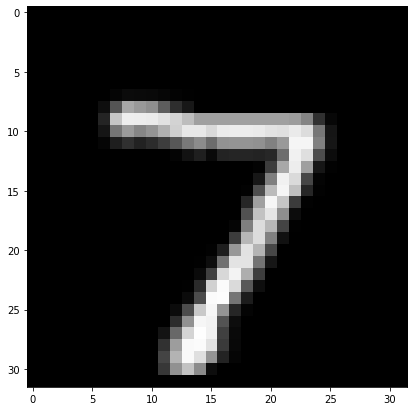

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


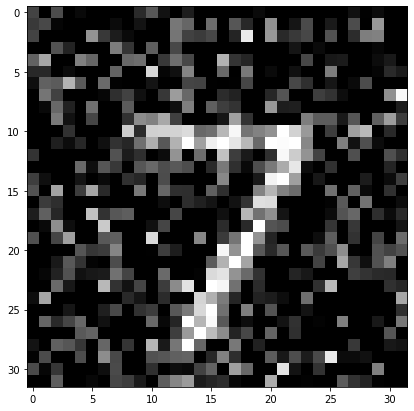

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))
dataiter = iter(med_noise_testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))